# Road Network Detection from Satellite Images

This notebook demonstrates how to train and use a UNet++ model to detect road networks from satellite imagery.

## Environment Setup and Required Libraries
Let's start by importing the necessary libraries for our project.

In [ ]:
# Import basic libraries for image processing and visualization
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set matplotlib style for clean figures
plt.style.use('seaborn-v0_8-paper')
%matplotlib inline

In [ ]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [ ]:
# Import computer vision and deep learning libraries
from torchvision import transforms, models
import segmentation_models_pytorch as smp

## Data Preparation

Let's define the dataset class and transformations required for loading and preprocessing our satellite imagery data.

In [ ]:
# Define the Rescale transformation class
class Rescale:
    """Rescale the image and mask to a given size.
    
    Args:
        output_size (tuple or int): Desired output size. If tuple, output is matched to output_size.
                                    If int, the smaller of image edges is matched to output_size keeping aspect ratio.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = int(self.output_size * h / w), self.output_size
            else:
                new_h, new_w = self.output_size, int(self.output_size * w / h)
        else:
            new_h, new_w = self.output_size

        image = cv2.resize(image, (new_w, new_h))
        mask = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)
        return {"image": image, "mask": mask}

# Define the ToTensor transformation class
class ToTensor:
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        # Normalize image to [0, 1]
        image = image.astype(np.float32) / 255.0
        # Apply ImageNet normalization (for display, we revert normalization later)
        image = (image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
        # Convert H x W x C to C x H x W
        image = np.transpose(image, (2, 0, 1))
        # Expand mask to have channel dimension and ensure type is float32
        mask = np.expand_dims(mask, axis=0).astype(np.float32)
        return {"image": torch.tensor(image), "mask": torch.tensor(mask)}

# Compose the transformations
data_transforms = transforms.Compose([
    Rescale((512, 512)),
    ToTensor()
])

In [ ]:
# Update the SatelliteRoadDataset class to handle the current file naming convention and ensure robustness.
class SatelliteRoadDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (str): Directory with images and masks together.
                            Assumes each image is named like 'image1_sat.jpg'
                            and its corresponding mask is named 'image1_mask.png'.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_dir = data_dir
        # Get all image files that contain '_sat' in the filename.
        self.image_paths = sorted([p for p in glob(os.path.join(data_dir, "*_sat.*"))])
        self.transform = transform

        if not self.image_paths:
            raise ValueError(f"No satellite images found in directory: {data_dir}")

        # Filter out images without corresponding masks
        valid_image_paths = []
        for img_path in self.image_paths:
            mask_path = img_path.replace("_sat.jpg", "_mask.png")
            if os.path.exists(mask_path):
                valid_image_paths.append(img_path)
            else:
                print(f"Warning: Mask not found for image: {img_path}. Skipping this file.")

        self.image_paths = valid_image_paths

        if not self.image_paths:
            raise ValueError(f"No valid image-mask pairs found in directory: {data_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = image_path.replace("_sat.jpg", "_mask.png")

        # Read the image and mask files
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Handle corrupt or missing images/masks
        if image is None or mask is None:
            print(f"[WARN] Skipping broken file: {image_path} or {mask_path}")
            # Return a different valid sample instead of raising an error
            return self.__getitem__((idx + 1) % len(self.image_paths))  # Try the next image

        # Process the mask
        _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)

        sample = {"image": image.astype(np.float32), "mask": mask.astype(np.float32)}

        if self.transform:
            sample = self.transform(sample)

        # Ensure float32 tensors before returning
        sample["image"] = sample["image"].float()
        sample["mask"] = sample["mask"].float()

        return sample

## Data Visualization

Let's visualize some of our data samples to ensure everything is loading correctly.

In [ ]:
# Visualize some preprocessed data samples.
def visualize_sample(sample):
    # Convert image tensor back to numpy and revert ImageNet normalization for display.
    image = sample['image'].numpy().transpose(1, 2, 0)
    image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
    image = np.clip(image, 0, 1)
    mask = sample['mask'].numpy().squeeze()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title("Preprocessed Image")
    axes[0].axis("off")
    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Binary Road Mask")
    axes[1].axis("off")
    plt.show()

In [ ]:
# Initialize the dataset with proper path
dataset = SatelliteRoadDataset(r"C:\Users\kisho\OneDrive\Desktop\roadnet_minimalg\data\archive\train", transform=data_transforms)
print(f"Dataset contains {len(dataset)} samples")

# Visualize a sample
visualize_sample(dataset[32])

## Model Definition

We'll use a UNet++ architecture with EfficientNet-B4 encoder for our road segmentation task.

In [ ]:
class RoadSegmentationModel(nn.Module):
    def __init__(self, encoder_name='efficientnet-b4', pretrained=True, out_classes=1, activation=None):
        super(RoadSegmentationModel, self).__init__()
        # We use UNet++ which has proven effective in boundary detection and complex segmentation
        self.model = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_weights='imagenet' if pretrained else None,
            in_channels=3,
            classes=out_classes,
            activation=activation
        )

    def forward(self, x):
        out = self.model(x)
        return {'out': out}

# Helper function to get the model
def get_model(config):
    arch = config.get('model', {}).get('architecture', 'unetplusplus')
    num_classes = config.get('model', {}).get('classes', 1)
    encoder_name = config.get('model', {}).get('encoder_name', 'efficientnet-b4')
    encoder_weights = config.get('model', {}).get('encoder_weights', 'imagenet')
    activation = config.get('model', {}).get('activation', None)
    
    if 'unetplusplus' in arch.lower():
        model = RoadSegmentationModel(
            encoder_name=encoder_name,
            pretrained=(encoder_weights is not None),
            out_classes=num_classes,
            activation=activation
        )
    else:
        raise ValueError("Only 'unetplusplus' model is supported in this pipeline.")
    return model

In [ ]:
# Example configuration dictionary
config = {
    "model": {
        "architecture": "unetplusplus",
        "encoder_name": "efficientnet-b4",
        "encoder_weights": "imagenet",
        "activation": None,
        "classes": 1,
        "in_channels": 3
    },
    "train": {
        "learning_rate": 1e-4,
        "weight_decay": 1e-5,
        "batch_size": 4,
        "epochs": 25,
    }
}

# Instantiate the model and print its summary
model = get_model(config)
print(model)

## Loss Function and Optimizer

For road segmentation, we'll use a combination of Binary Cross-Entropy and Dice Loss, which works well for unbalanced datasets (roads typically occupy a small portion of satellite images).

In [ ]:
def dice_loss(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
    
    def forward(self, pred, target):
        return self.bce(pred, target) + dice_loss(pred, target)

# Update training configuration for memory efficiency
config["train"]["batch_size"] = 1  # Reduced for memory constraints

# Select optimizer and loss function based on configuration
optimizer = optim.Adam(model.parameters(), lr=config["train"]["learning_rate"], weight_decay=config["train"].get("weight_decay", 0))
criterion = DiceBCELoss()  # Combined BCE and Dice loss

## Model Training

Let's define our training function and prepare a subset of data for training.

In [ ]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=25, device='cuda'):
    model = model.to(device)
    # Ensure model parameters are float32
    for param in model.parameters():
        param.data = param.data.float()
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Wrap dataloader with tqdm for progress monitoring
        pbar = tqdm(dataloader, desc=f"Training")
        for batch_idx, batch in enumerate(pbar):
            images = batch["image"].to(device).float()
            masks = batch["mask"].to(device).float()

            optimizer.zero_grad()
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            current_loss = loss.item()
            epoch_losses.append(current_loss)
            
            # Update progress bar with current loss
            pbar.set_postfix(loss=f"{current_loss:.4f}")

        avg_loss = np.mean(epoch_losses)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # Save checkpoint if improved
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'best_loss': best_loss
            }, 'best_checkpoint.pth')
    return model

In [ ]:
# Create a subset dataset for efficient training (10% of full dataset)
full_dataset = SatelliteRoadDataset(r"C:\Users\kisho\OneDrive\Desktop\roadnet_minimalg\data\archive\train", transform=data_transforms)
print(f"Full dataset size: {len(full_dataset)} samples")

# Create a smaller subset for training
from torch.utils.data import Subset
import random

# Use a fixed seed for reproducibility
random.seed(42)

# Select 10% of the data for training
subset_size = int(len(full_dataset) * 0.10)
subset_indices = random.sample(range(len(full_dataset)), subset_size)
train_subset = Subset(full_dataset, subset_indices)

print(f"Using a subset of {len(train_subset)} samples for training")
dataloader = DataLoader(train_subset, batch_size=config["train"]["batch_size"], shuffle=True, num_workers=0)

## Start Training

Now we're ready to start training the model.

In [ ]:
# Set the device to use for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Train the model
trained_model = train_model(
    model,
    dataloader,
    criterion,
    optimizer,
    num_epochs=config["train"]["epochs"],
    device=device
)

## Loading Trained Model and Improved Checkpoint Handling

The following code shows how to properly load a trained model with robust error handling for different PyTorch versions.

In [ ]:
# Clear CUDA memory cache and check if CUDA is available
torch.cuda.empty_cache()
print(f"CUDA available: {torch.cuda.is_available()}")

# Reload the model from the best checkpoint
checkpoint_path = 'best_checkpoint.pth'
try:
    # First try loading with weights_only=False (PyTorch 2.6+ compatibility)
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    print("Loaded checkpoint with weights_only=False")
except (TypeError, ValueError):
    # For older PyTorch versions, try without the weights_only parameter
    try:
        checkpoint = torch.load(checkpoint_path)
        print("Loaded checkpoint with default parameters")
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        # If you specifically trust this source, you might try the following
        # Import the necessary functions for safe global handling
        import torch.serialization
        from numpy.core.multiarray import scalar
        # Add the scalar to safe globals
        torch.serialization.add_safe_globals([scalar])
        checkpoint = torch.load(checkpoint_path)
        print("Loaded checkpoint with additional safe globals")

# Load state dict into the model
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model checkpoint from epoch {checkpoint['epoch']} with loss {checkpoint['best_loss']:.4f}")

## Model Inference and Visualization

Let's create a function to run inference on new images and visualize the results.

In [35]:
# Simplified predict function that handles device management internally
def predict_and_visualize(model, pil_image, threshold=0.5):
    # Always use CUDA if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Make sure model is in eval mode
    model.eval()
    model = model.to(device)
    
    # Preprocess input image similar to training pipeline
    image_np = np.array(pil_image.resize((512, 512)))
    
    # Convert to float and normalize
    image = image_np.astype(np.float32) / 255.0
    image = (image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    
    # Convert to tensor and add batch dimension
    image = torch.from_numpy(image.transpose(2, 0, 1)).unsqueeze(0).float().to(device)
    
    with torch.no_grad():
        output = model(image)['out']
        sigmoid_output = torch.sigmoid(output).squeeze().cpu().numpy()
    
    # Create binary mask
    binary_mask = (sigmoid_output > threshold).astype(np.uint8)
    
    # Create overlay visualization
    overlay = image_np.copy()
    overlay[binary_mask == 1] = [255, 0, 0]  # Red for roads
    blended = (0.6 * image_np + 0.4 * overlay).astype(np.uint8)
    
    # Visualize results
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(image_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(sigmoid_output, cmap="viridis")
    axes[1].set_title("Raw Sigmoid Output")
    axes[1].axis("off")
    
    axes[2].imshow(binary_mask, cmap="gray")
    axes[2].set_title("Binary Road Mask")
    axes[2].axis("off")
    
    axes[3].imshow(blended)
    axes[3].set_title("Overlay (Prediction)")
    axes[3].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Prediction Range — Min: {sigmoid_output.min():.4f}, Max: {sigmoid_output.max():.4f}, Mean: {sigmoid_output.mean():.4f}")
    
    return binary_mask, blended

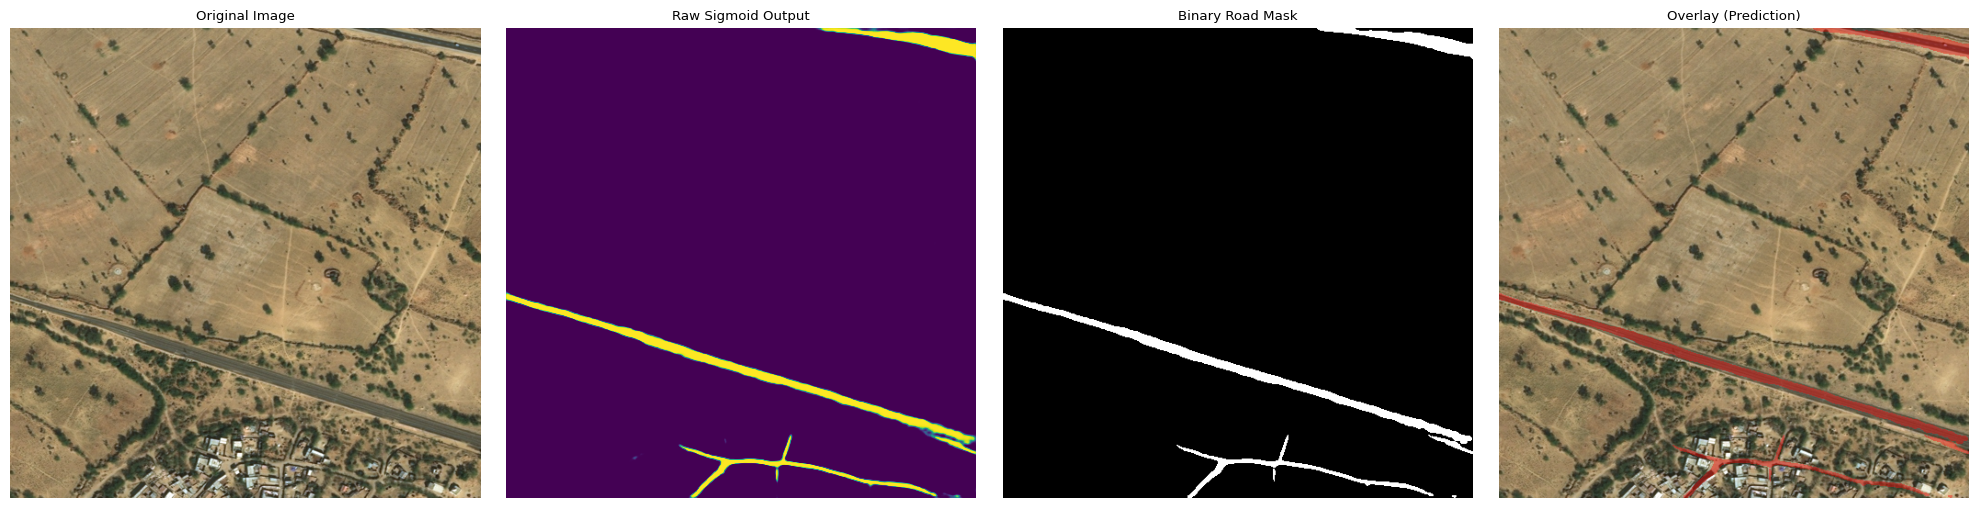

Prediction Range — Min: 0.0000, Max: 1.0000, Mean: 0.0308
Model is trained with CUDA and saved to best_checkpoint.pth


In [ ]:
# Load a sample image for testing
from PIL import Image
sample_image = Image.open(r"D:\naki\Projects\IVP\roadnet_minimal\data\archive\test\14369_sat.jpg").convert("RGB")

# Call the predict function
binary_mask, overlay = predict_and_visualize(model, sample_image, threshold=0.5)

# Save the results
Image.fromarray(overlay).save('road_prediction.png')
print("Model inference successful and results saved to road_prediction.png")

## Save Model for Deployment

Finally, let's save the model properly for use in a production environment (like our Streamlit app).

In [ ]:
# Create a directory if needed
import os
os.makedirs("saved_models", exist_ok=True)

# Define the file name
model_path = "saved_models/roadnet_unet_weights.pth"

# Save only the model weights
torch.save(model.state_dict(), model_path)

print(f"✅ Model weights saved to '{model_path}' and ready for inference!")

# Loading snippet for reference
'''
# To load later for inference:
import segmentation_models_pytorch as smp
model = smp.UnetPlusPlus(encoder_name="efficientnet-b4", classes=1, in_channels=3)
model.load_state_dict(torch.load("saved_models/roadnet_unet_weights.pth", map_location="cpu"))
model.eval()
'''

✅ Model weights saved to 'saved_models/roadnet_unet_weights.pth' and ready for inference!
